In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import scipy.linalg
import os
from scipy.io import wavfile
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import convolve
from functools import lru_cache

In [2]:
path = '../../data/processed/'
sample_rate = 220

In [3]:
def read_wav(path):
    sr, samples = wavfile.read(path)
    
    #for s in samples.transpose():
    #    sample = resample(s.astype(np.float), orig_sr = sr, target_sr = sample_rate)
    #    sample = sample.astype(np.int16)
    return samples

def heavy_scan(path):
    files = {}
    for f in os.scandir(path):
        if f.is_dir():
            print(f.path)
            files[f.name] = heavy_scan(f.path)
        elif f.name[-4:] == '.wav':
            files[f.name] = read_wav(f.path)
    return files

In [4]:
path

'../../data/processed/'

In [5]:
files = heavy_scan(path)

../../data/processed/conditioned_inputs
../../data/processed/tapping
../../data/processed/tapping/tapping-plastic
../../data/processed/tapping/tapping-metal
../../data/processed/tapping/tapping-paper-cardboard
../../data/processed/tapping/tapping-wood
../../data/processed/tapping/tapping-wood/partial
../../data/processed/tapping/tapping-wood/partial/.ipynb_checkpoints
../../data/processed/tapping/tapping-wood/.ipynb_checkpoints
../../data/processed/tapping/tapping-glass
../../data/processed/tapping/tapping-glass/partial
../../data/processed/tapping/tapping-glass/.ipynb_checkpoints
../../data/processed/brushing
../../data/processed/brushing/brushing-fluffy-rode-mic
../../data/processed/brushing/brushing-cork
../../data/processed/brushing/brushing-zoom-sponge-mic
../../data/processed/brushing/brushing-rode-mic
../../data/processed/brushing/brushing-rode-mic/partial
../../data/processed/brushing/brushing-rode-mic/.ipynb_checkpoints
../../data/processed/brushing/brushing-zoom-mic
../../dat

In [6]:
sample_brushing = files['brushing']['brushing-rode-mic']['H2Cam080Ye8-silicon-brush.wav']
sample_whispering = files['whispering']['male']['-d1DKCpiwEg-whispering-male-1-1.wav']
sample_tapping = files['tapping']['tapping-plastic']['PLhDdb5CgZ4-plastic-bottle.wav']

In [7]:
del files

## Silent areas

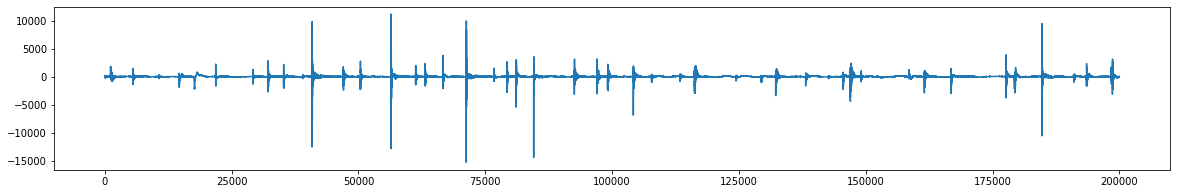

## Stereo

In [16]:
channels_diff = sample_tapping[:,0] - sample_tapping[:,1]

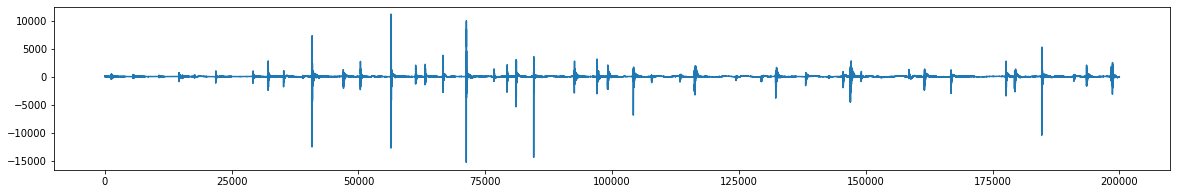

In [20]:
plt.plot(sample_tapping[:,0][600000:800000])

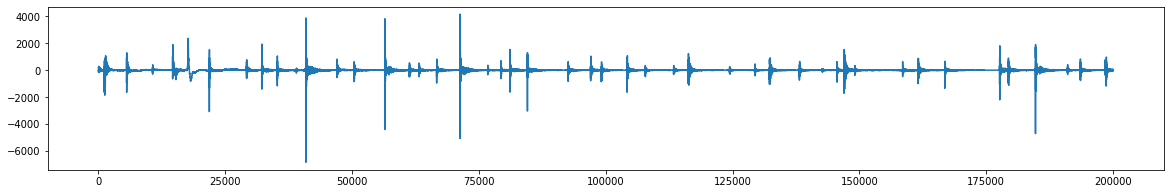

In [21]:
plt.plot(sample_tapping[:,1][600000:800000])

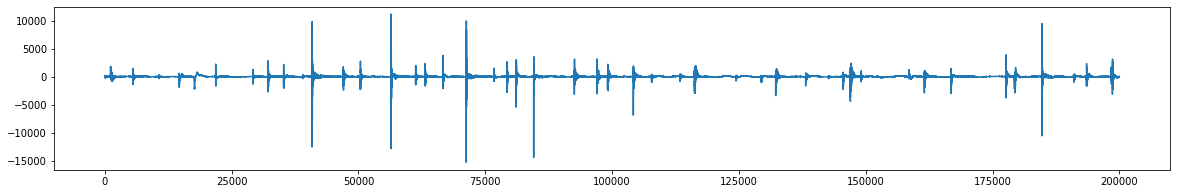

In [22]:
plt.plot(channels_diff[600000:800000])

In [11]:
y = channels_diff[:(48000 * 20)]
y = scipy.signal.convolve(y, np.ones(70000)/70000)[[i*5000 for i in range((len(y)-1)//5000)]]
xold = np.array(range(len(y)))

In [12]:
xnew = np.linspace(xold.min(), xold.max(), 50)
spl = make_interp_spline(xold, y, k=11)
power_smooth = spl(xnew)

In [13]:
xnew2 = np.linspace(xnew.min(), xnew.max(), 500)
spl = make_interp_spline(xnew, power_smooth, k=3)
power_smooth2 = spl(xnew2)

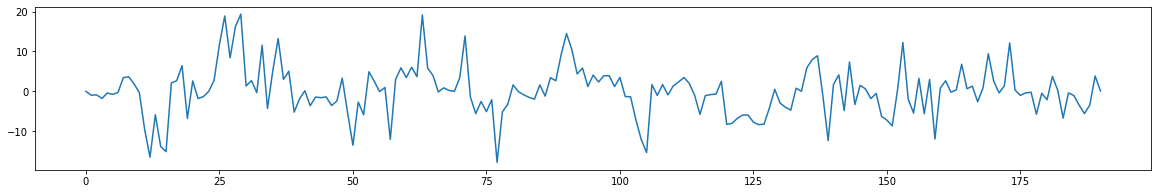

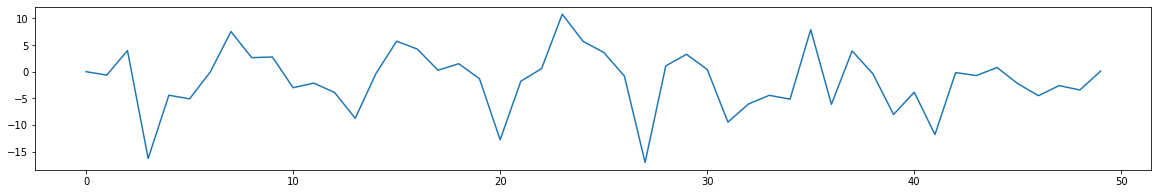

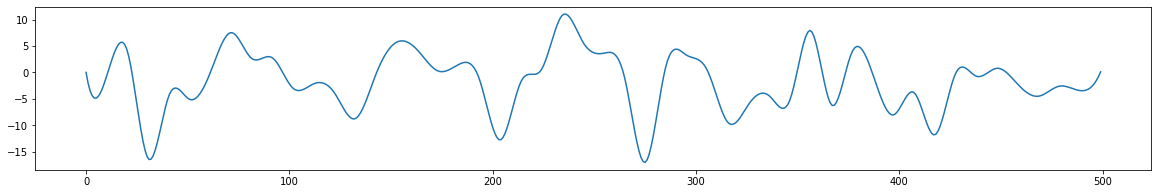

In [14]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(y)
plt.show()
plt.plot(power_smooth)
plt.show()
plt.plot(power_smooth2)
plt.show()

## Frequency

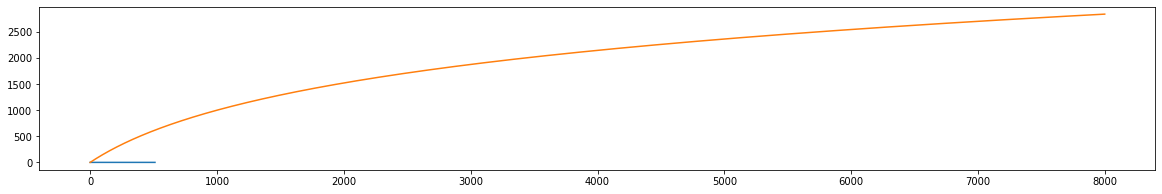

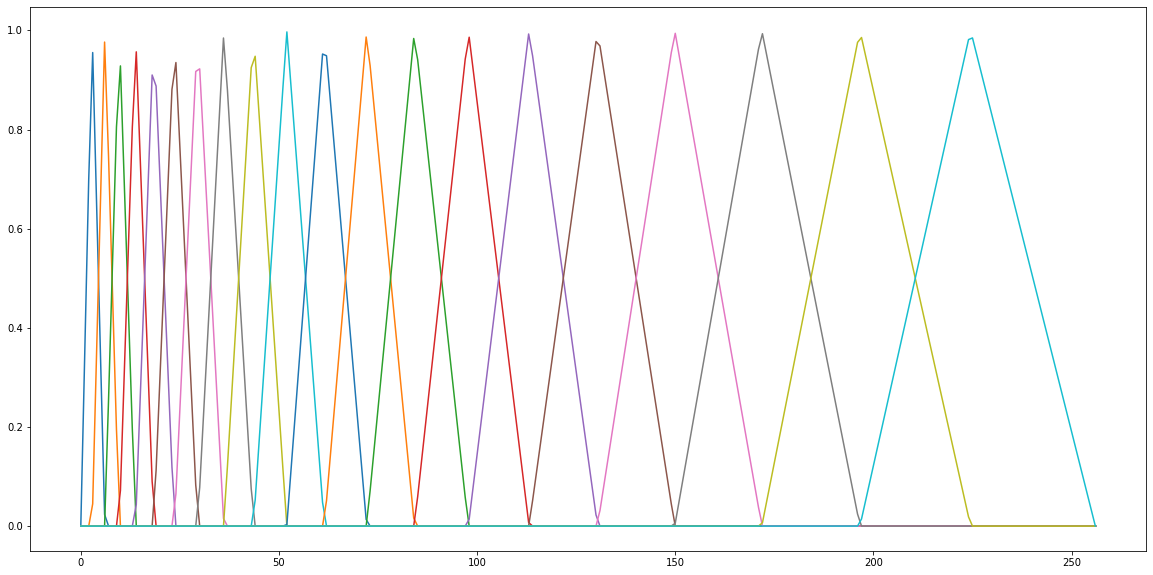

In [23]:
# Hamming window
@lru_cache(maxsize=10)
def get_window(n, type='hamming'):
    coefs = np.arange(n)
    window = 0.54 - 0.46 * np.cos(2 * np.pi * coefs / (n - 1))
    return window
plt.plot(get_window(512))

# Preemphasis filter
def apply_preemphasis(y, preemCoef=0.97):
    y[1:] = y[1:] - preemCoef*y[:-1]
    y[0] *= (1 - preemCoef)
    return y

def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)
plt.plot(freq_to_mel(np.arange(8000)))


def mel_to_freq(mels):
    return 700.0 * (np.power(10.0, mels / 2595.0) - 1.0)

@lru_cache(maxsize=10)
def get_filterbank(numfilters, filterLen, lowFreq, highFreq, samplingFreq):
    minwarpfreq = freq_to_mel(lowFreq)
    maxwarpfreq = freq_to_mel(highFreq)
    dwarp = (maxwarpfreq - minwarpfreq) / (numfilters + 1)
    f = mel_to_freq(np.arange(numfilters + 2) * dwarp + minwarpfreq) * (filterLen - 1) * 2.0 / samplingFreq
    i = np.arange(filterLen)[None, :]
    f = f[:, None]
    hislope = (i - f[:numfilters]) / (f[1:numfilters+1] - f[:numfilters])
    loslope = (f[2:numfilters+2] - i) / (f[2:numfilters+2] - f[1:numfilters+1])
    H = np.maximum(0, np.minimum(hislope, loslope))
    return H
H = get_filterbank(numfilters=20, filterLen=257, lowFreq=0, highFreq=8000, samplingFreq=16000)
fig = plt.figure(figsize=(20,10))
for h in H:
  plt.plot(h)

def normalized(y, threshold=0):
    y -= y.mean()
    stddev = y.std()
    if stddev > threshold:
        y /= stddev
    return y


def mfsc(y, sfr, window_size=0.025, window_stride=0.010, window='hamming', normalize=False, log=True, n_mels=20, preemCoef=0, melfloor=1.0):
    win_length = int(sfr * window_size)
    hop_length = int(sfr * window_stride)
    n_fft = 512
    lowfreq = 0
    highfreq = sfr/2
    
    # get window
    window = get_window(win_length)
    padded_window = np.pad(window, (0, n_fft - win_length), mode='constant')[:, None]
    
    # preemphasis
    y = apply_preemphasis(y.copy(), preemCoef)

    # scale wave signal
    y *= 32768
    
    # get frames
    num_frames = 1 + (len(y) - win_length) // hop_length
    pad_after = num_frames*hop_length + (n_fft - hop_length) - len(y)
    if pad_after > 0:
        y = np.pad(y, (0, pad_after), mode='constant')
    frames = np.lib.stride_tricks.as_strided(y, shape=(n_fft, num_frames), strides=(y.itemsize, hop_length * y.itemsize), writeable=False)
    windowed_frames = padded_window * frames
    D = np.abs(np.fft.rfft(windowed_frames, axis=0))

    # mel filterbank
    filterbank = get_filterbank(n_mels, n_fft/2 + 1, lowfreq, highfreq, sfr)
    mf = np.dot(filterbank, D)
    mf = np.maximum(melfloor, mf)
    if log:
        mf = np.log(mf)
    if normalize:
        mf = normalized(mf)

    return mf

def mfsc2mfcc(S, n_mfcc=11, dct_type=2, norm='ortho', lifter=22, cms=True, cmvn=True):
    # Discrete Cosine Transform
    M = scipy.fftpack.dct(S, axis=0, type=dct_type, norm=norm)[:n_mfcc]
    
    M_d = M[:, 1:] - M[:, :-1]
    
    M = np.concatenate((M, M_d), axis = 1)
    
    # Ceptral mean subtraction (CMS) 
    if cms or cmvn:
        M -= M.mean(axis=1, keepdims=True)

    # Ceptral mean and variance normalization (CMVN)
    if cmvn:
        M /= M.std(axis=1, keepdims=True)
    
    # Liftering
    elif lifter > 0:
        print("liftering...")
        lifter_window = 1 + (lifter / 2) * np.sin(np.pi * np.arange(1, 1 + n_mfcc, dtype=M.dtype) / lifter)[:, np.newaxis]
        M *= lifter_window
        
    
        
    return M, M_d


ValueError: index can't contain negative values

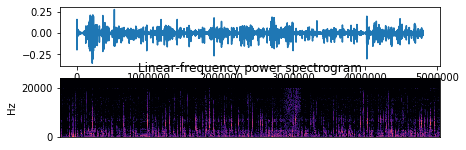

In [17]:
import librosa
import librosa.display


i = 0
y = sample_whispering.sum(axis = 1)/2
sfr = 48000
y = y/32768
#print(wav, 'Sampling frequency: ', sfr)
fig = plt.subplot(4,2,i+1)
plt.plot(y)

# Liner frequency spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig = plt.subplot(4,2,i+3)
librosa.display.specshow(D, y_axis='linear', sr=sfr)
plt.title('Linear-frequency power spectrogram')

# Mel-scaled spectrogram (20 bank filters)
S = mfsc(y, sfr)
fig = plt.subplot(4,2,i+5)
librosa.display.specshow(S - S.min())
plt.title('Mel-scaled power spectrogram')
#print(S.shape)
#print("-------")

# MFCC(5)
M = mfsc2mfcc(S)

960000


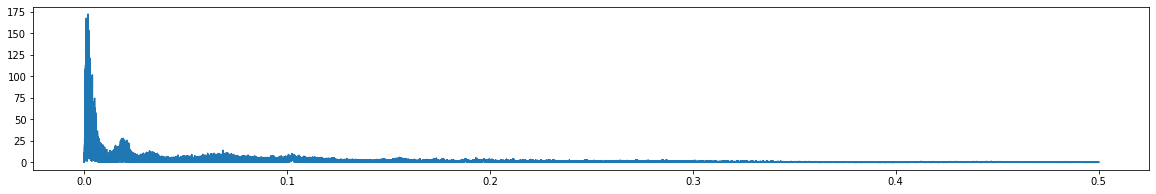

In [24]:
# Number of samplepoints
N = 480000
# sample spacing
T = 1
x = np.linspace(0.0, N*T, N)
y = sample_whispering.sum(axis = 1)[:(48000 * 20)]
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)


print(len(yf))
fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

In [53]:
import scipy.io.wavfile as wav
import scipy.signal as signal
from matplotlib import pyplot as plt

def stft(sample, i, sr = 48000, nperseg = 1024, nfft = 1024, max_freq = -1):
    fig = plt.subplot(i+1,1,1)
    sample_rate, samples = sr, sample[:(48000*1)]
    f, t, Zxx = signal.stft(samples, fs=sample_rate, nperseg = nperseg, nfft = nfft)
    plt.pcolormesh(t, f[:max_freq], np.log(np.abs(Zxx))[:max_freq,:])

In [52]:
import librosa
import librosa.display
fig = plt.figure(figsize=(20,15))
for i in range(2):
    wav = free10x4x4[i]['wav']
    sfr, y = scipy.io.wavfile.read(wav)
    y = y/32768
    print(wav, 'Sampling frequency: ', sfr)
    fig = plt.subplot(4,2,i+1)
    plt.plot(y)

    # Liner frequency spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    fig = plt.subplot(4,2,i+3)
    librosa.display.specshow(D, y_axis='linear', sr=sfr)
    plt.title('Linear-frequency power spectrogram')

    # Mel-scaled spectrogram (20 bank filters)
    S = mfsc(y, sfr)
    fig = plt.subplot(4,2,i+5)
    librosa.display.specshow(S - S.min())
    plt.title('Mel-scaled power spectrogram')

    # MFCC(5)
    M = mfsc2mfcc(S)
    fig = plt.subplot(4,2,i+7)
    plt.plot(M[1,:])

NameError: name 'free10x4x4' is not defined

<Figure size 1440x1080 with 0 Axes>

In [60]:
sr = 48000
nperseg = 1024
nfft = 1024
max_freq = -1

In [ ]:
fig, ax = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
sample = 
sample_rate, samples = sr, sample[:(48000*1)]
f, t, Zxx = signal.stft(samples, fs=sample_rate, nperseg = nperseg, nfft = nfft)
plt.pcolormesh(t, f[:max_freq], np.log(np.abs(Zxx))[:max_freq,:])
ax1.plot(x, y)
ax2.plot(x, -y)

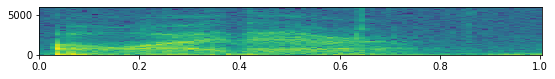

In [58]:
# plt.rcParams["figure.figsize"] = (15,5)
fig, ax = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
ax1.plot(x, y)
ax2.plot(x, -y)
stft(sample_tapping.sum(axis=1)/2, 0, max_freq = 512)
stft(sample_brushing.sum(axis=1)/2, 1, max_freq = 512)
stft(sample_whispering.sum(axis=1)/2, 2, max_freq = 128)
plt.show()